Here, we test code specifically for accurately measuring the radii of random directions for a known 2d loss landscape, where the radii correspond to the filter normalized perturbation directions.

In plain english, instead of absolute perturbations in weight space, we consider fractional perturbations, aka perturbations that multiple or divide the current weight.

Most things are the same as our old code.

### Loss Landscape and Model

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List

class LossLandscape:
    def __init__(self, 
                 minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2,
                 amplitude=1.0,
                 baseline=1.0):
        """
        Initialize a customizable loss landscape with two minima.
        """
        self.minima_sharp_loc = minima_sharp_loc
        self.minima_wide_loc = minima_wide_loc
        self.sharp_width = sharp_width
        self.wide_width = wide_width
        self.amplitude = amplitude
        self.baseline = baseline
        
    def get_minima_parameters(self):
        """Return the key parameters defining the minima"""
        return {
            'minima_sharp_loc': self.minima_sharp_loc,
            'minima_wide_loc': self.minima_wide_loc,
            'sharp_width': self.sharp_width,
            'wide_width': self.wide_width
        }
        
    def __call__(self, x):
        """Compute the loss at point(s) x"""
        gaussian_sharp = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_sharp_loc) / self.sharp_width)**2
        )
        gaussian_wide = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_wide_loc) / self.wide_width)**2
        )
        return self.baseline - gaussian_sharp - gaussian_wide
    
    def visualize(self, x_range=(-2, 2), num_points=500):
        """Visualize the loss landscape"""
        x = torch.linspace(x_range[0], x_range[1], num_points)
        loss = self(x)
        
        plt.figure(figsize=(8, 5))
        plt.plot(x.numpy(), loss.numpy())
        plt.xlabel('x')
        plt.ylabel('Loss')
        plt.title('Loss Landscape')
        
        plt.axvline(x=self.minima_sharp_loc, color='r', 
                   linestyle='--', alpha=0.3, label='Sharp minimum')
        plt.axvline(x=self.minima_wide_loc, color='b', 
                   linestyle='--', alpha=0.3, label='Wide minimum')
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    def random_parameter_search(self, dim: int, num_samples: int = 10000, upper = 10, low = -10):
        """
        Perform random parameter search using the class's minima parameters
        
        Args:
            dim: Dimension of parameter space
            num_samples: Number of random samples to generate
            
        Returns:
            Tuple of (sharp_count, wide_count, samples)
        """
        minima_sharp_count = 0
        minima_wide_count = 0
        samples = []
        
        for _ in range(num_samples):
            params = np.random.uniform(low=low, high=upper, size=dim)
            product = np.prod(params)
            samples.append(product)
            
            if abs(product - self.minima_sharp_loc) < self.sharp_width:
                minima_sharp_count += 1
            if abs(product - self.minima_wide_loc) < self.wide_width:
                minima_wide_count += 1
        
        return minima_sharp_count, minima_wide_count, samples
        
class NParameterModel(torch.nn.Module):
    def __init__(self, initial_values: List[float]):
        super().__init__()
        # Create N parameters from the initial values
        self.params = torch.nn.ParameterList([
            torch.nn.Parameter(torch.tensor([val], dtype=torch.float32))
            for val in initial_values
        ])
    
    def forward(self):
        # Compute product of all parameters
        x = torch.prod(torch.stack([p for p in self.params]))
        return x

    def get_parameter_values(self):
        return [p.item() for p in self.params]

### Random Directions, Wiggle, Loss Threshold, Visualizations

In [2]:
# Importing our existing funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from perturb_simple import (
    generate_random_perturbations,
    wiggle_multiple_directions,
    loss_threshold_crossing,
)

from visualize_2d import (
    plot_parameter_space_with_arrows,
    plot_parameter_space_with_polygon,
)

## In our case, we might also use a generate circular perturbations a lot
def generate_circular_perturbations(num_vectors):
    """
    Generate evenly spaced unit vectors around a circle using only PyTorch.
    """
    angles = torch.linspace(0, 2 * torch.pi, num_vectors + 1)[:-1]  # Evenly spaced, exclude duplicate 2π
    x = torch.cos(angles)
    y = torch.sin(angles)
    
    return [
        {'params.0': x[i].reshape(1), 'params.1': y[i].reshape(1)} 
        for i in range(num_vectors)
    ]

Our loss landscape instance, model, the perturbations, and coefficients to evaluate searching for the boundary.

In [3]:
# Initialize our loss landscape
minima_sharp_loc=-1.0, 
minima_wide_loc=1.0,
sharp_width=0.1,
wide_width=0.2
loss_fn = LossLandscape(minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2)

# Model
scale = 2.0
model_example = NParameterModel([scale, 1/scale])

# Generate perturbation directions
num_perturb_directions = 10
perturb_vectors = generate_circular_perturbations(num_perturb_directions)

# Coefficients to sample
N = 101
coefficients = np.linspace(0, 2, N)

# The loss is 1 - gaussian_sharp, which is 0.3935
loss_threshold = 0.3935

# Filter Normalization

The big difference with filter normalization is that after generating normalized perturbations, we multiply them by the scale of weights. Therefore they become a fractional perturbation to the weights instead, and a perturbation of say -1 to some weight which normally is

- weight - 1

instead becomes

- weight - 1 * weight = 0

It's relatively easy to implement, since it just means changing the perturbation vector.

In [4]:
def filtnorm(named_parameters):
    """
    Return filter norms as a dictionary.
    
    Args:
        named_parameters: Iterator of (name, parameter) tuples (from model.named_parameters())
    Returns:
        Dictionary {param_name: norm_tensor} or list of norm tensors (maintaining original order)
    """
    norm_dict = {}
    
    for name, param in named_parameters:
        param = param.detach()  # <-- Critical addition
        shape = param.shape
        stacked = torch.ones_like(param)*param
        
        norm_dict[name] = stacked
    
    return norm_dict

In [5]:
norm_dict = filtnorm(model_example.named_parameters())      # Returns {name: tensor}
print (norm_dict)

{'params.0': tensor([2.]), 'params.1': tensor([0.5000])}


Perturbation vectors with and without the normalization.

In [6]:
# Create normalized vectors
normalized_vectors = []
for vector in perturb_vectors:
    normalized_vector = {}
    for key in vector.keys():
        normalized_vector[key] = vector[key] * norm_dict[key]
    normalized_vectors.append(normalized_vector)

# To verify the results:
for i, vec in enumerate(normalized_vectors):
    print(f"Vector {i}: \n{vec}")
    print(f"Orig: {perturb_vectors[i]}")

Vector 0: 
{'params.0': tensor([2.]), 'params.1': tensor([0.])}
Orig: {'params.0': tensor([1.]), 'params.1': tensor([0.])}
Vector 1: 
{'params.0': tensor([1.6180]), 'params.1': tensor([0.2939])}
Orig: {'params.0': tensor([0.8090]), 'params.1': tensor([0.5878])}
Vector 2: 
{'params.0': tensor([0.6180]), 'params.1': tensor([0.4755])}
Orig: {'params.0': tensor([0.3090]), 'params.1': tensor([0.9511])}
Vector 3: 
{'params.0': tensor([-0.6180]), 'params.1': tensor([0.4755])}
Orig: {'params.0': tensor([-0.3090]), 'params.1': tensor([0.9511])}
Vector 4: 
{'params.0': tensor([-1.6180]), 'params.1': tensor([0.2939])}
Orig: {'params.0': tensor([-0.8090]), 'params.1': tensor([0.5878])}
Vector 5: 
{'params.0': tensor([-2.]), 'params.1': tensor([-4.3711e-08])}
Orig: {'params.0': tensor([-1.]), 'params.1': tensor([-8.7423e-08])}
Vector 6: 
{'params.0': tensor([-1.6180]), 'params.1': tensor([-0.2939])}
Orig: {'params.0': tensor([-0.8090]), 'params.1': tensor([-0.5878])}
Vector 7: 
{'params.0': tensor(

We can evaluate the radius in our old method with our old vectors, or the filter normalized vectors. We compare their results and the volumes obtained.

In [7]:
results = wiggle_multiple_directions(model = model_example, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients, verbose =True)

r_values, valid_directions = loss_threshold_crossing(results, loss_threshold = loss_threshold)

norm_results = wiggle_multiple_directions(model = model_example, loss_fn = loss_fn, 
                                     perturbation_directions = normalized_vectors, 
                                    coefficients = coefficients, verbose =True)

norm_r_values, norm_valid_directions = loss_threshold_crossing(norm_results, loss_threshold = loss_threshold)

Evaluating direction 1/10...
Evaluating direction 2/10...
Evaluating direction 3/10...
Evaluating direction 4/10...
Evaluating direction 5/10...
Evaluating direction 6/10...
Evaluating direction 7/10...
Evaluating direction 8/10...
Evaluating direction 9/10...
Evaluating direction 10/10...
Evaluating direction 1/10...
Evaluating direction 2/10...
Evaluating direction 3/10...
Evaluating direction 4/10...
Evaluating direction 5/10...
Evaluating direction 6/10...
Evaluating direction 7/10...
Evaluating direction 8/10...
Evaluating direction 9/10...
Evaluating direction 10/10...


We can print out the list of radius values, or plot it using our good visualization code.

Original values  [0.4, 0.12, 0.08, 0.1, 0.32, 0.4, 0.12, 0.08, 0.1, 0.22]
Normalized values  [0.2, 0.12, 0.14, 0.36, 0.44, 0.2, 0.14, 0.16, 0.26, 0.92]
Wide loc  1.0
Wide loc  1.0


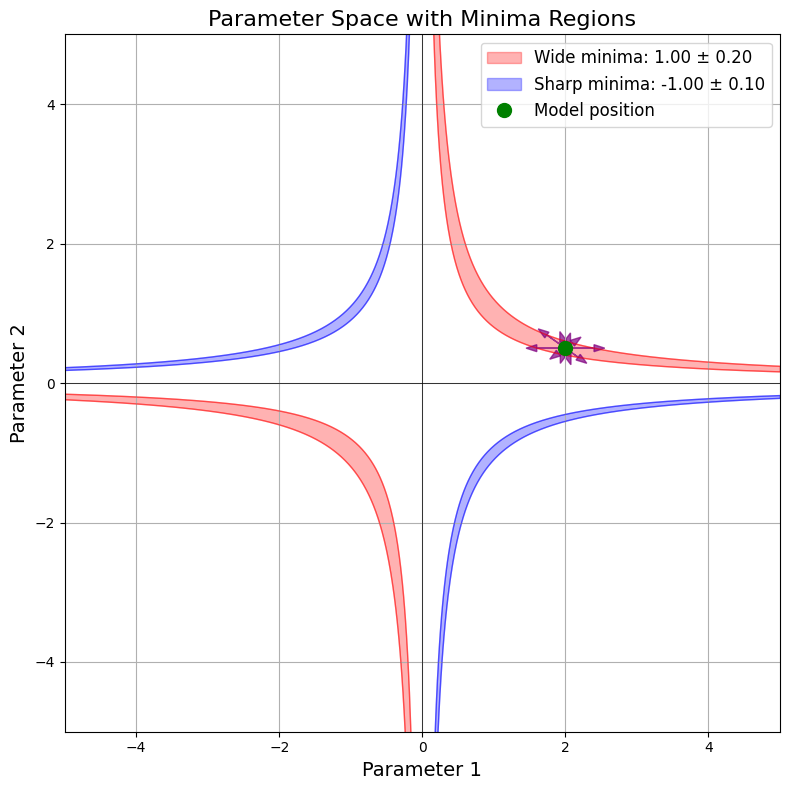

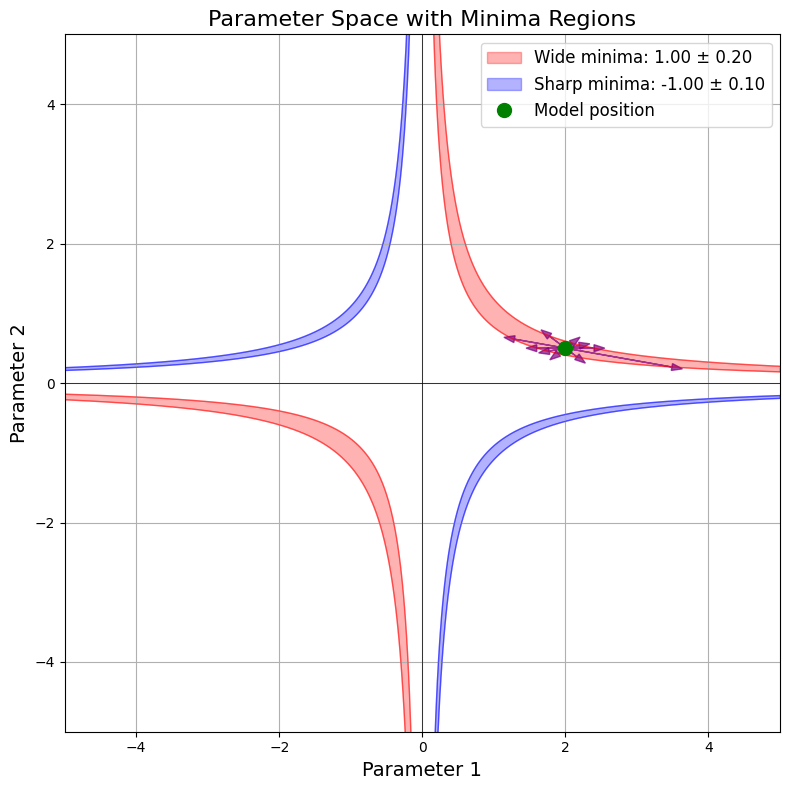

In [8]:
print ("Original values ", r_values)
print ("Normalized values ", norm_r_values)

plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model_example,
    perturbation_directions=perturb_vectors,
    r_values=r_values,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

plot_parameter_space_with_arrows(
    loss_fn=loss_fn,
    model=model_example,
    perturbation_directions=normalized_vectors,
    r_values=norm_r_values,
    x_min=-5, x_max=5,
    y_min=-5, y_max=5,
    fig_size = (8, 8)
)

Can also test the volume given by these methods.

In [9]:
import random
def compute_sampled_volume(r_values, K, dimension):
    # Select K random elements (without replacement)
    sampled_r = random.sample(r_values, K)
    rn_values = [r ** dimension for r in sampled_r]
    volume = sum(rn_values) / len(rn_values)
    return volume

In [10]:
orig_volume = compute_sampled_volume(r_values, len(r_values), 2)
normalized_volume = compute_sampled_volume(norm_r_values, len(r_values), 2)

print ("The original volume was ", orig_volume)
print ("The normalized volume was ", normalized_volume)

The original volume was  0.053239999999999996
The normalized volume was  0.13964000000000001


Quickly, for a different scale.

In [11]:
# Model
scale = 4.0
model_example2 = NParameterModel([scale, 1/scale])

norm_dict = filtnorm(model_example2.named_parameters()) 

normalized_vectors2 = []
for vector in perturb_vectors:
    normalized_vector = {}
    for key in vector.keys():
        normalized_vector[key] = vector[key] * norm_dict[key]
    normalized_vectors2.append(normalized_vector)

results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients)#, verbose =True)

r_values2, valid_directions = loss_threshold_crossing(results2, loss_threshold = loss_threshold)

norm_results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = normalized_vectors2, 
                                    coefficients = coefficients)#, verbose =True)

norm_r_values2, norm_valid_directions = loss_threshold_crossing(norm_results2, loss_threshold = loss_threshold)

In [12]:
orig_volume2 = compute_sampled_volume(r_values2, len(r_values), 2)
normalized_volume2 = compute_sampled_volume(norm_r_values2, len(r_values), 2)

print ("The original volume was ", orig_volume2)
print ("The normalized volume was ", normalized_volume2)

The original volume was  0.13064000000000003
The normalized volume was  0.13964000000000004


# Large Scale

We know the perturbation vector approach is poorly behaved unless the number of vectors is very large. Here we test both approahces using large numbers.

In [13]:
num_perturb_directions = 500
perturb_vectors = generate_circular_perturbations(num_perturb_directions)

# Model
scale = 2.0
model_example2 = NParameterModel([scale, 1/scale])

norm_dict = filtnorm(model_example2.named_parameters()) 

normalized_vectors2 = []
for vector in perturb_vectors:
    normalized_vector = {}
    for key in vector.keys():
        normalized_vector[key] = vector[key] * norm_dict[key]
    normalized_vectors2.append(normalized_vector)

results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients)#, verbose =True)

r_values2, valid_directions = loss_threshold_crossing(results2, loss_threshold = loss_threshold)

norm_results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = normalized_vectors2, 
                                    coefficients = coefficients)#, verbose =True)

norm_r_values2, norm_valid_directions = loss_threshold_crossing(norm_results2, loss_threshold = loss_threshold)

In [14]:
orig_volume2 = compute_sampled_volume(r_values2, len(r_values2), 2)
normalized_volume2 = compute_sampled_volume(norm_r_values2, len(r_values2), 2)

print ("The original volume was ", orig_volume2)
print ("The normalized volume was ", normalized_volume2)

The original volume was  0.18845680000000004
The normalized volume was  0.21084639999999932


In [15]:
# Model
scale = 1.0
model_example2 = NParameterModel([scale, 1/scale])

norm_dict = filtnorm(model_example2.named_parameters()) 

normalized_vectors2 = []
for vector in perturb_vectors:
    normalized_vector = {}
    for key in vector.keys():
        normalized_vector[key] = vector[key] * norm_dict[key]
    normalized_vectors2.append(normalized_vector)

results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = perturb_vectors, 
                                    coefficients = coefficients)#, verbose =True)

r_values2, valid_directions = loss_threshold_crossing(results2, loss_threshold = loss_threshold)

norm_results2 = wiggle_multiple_directions(model = model_example2, loss_fn = loss_fn, 
                                     perturbation_directions = normalized_vectors2, 
                                    coefficients = coefficients)#, verbose =True)

norm_r_values2, norm_valid_directions = loss_threshold_crossing(norm_results2, loss_threshold = loss_threshold)

In [16]:
orig_volume2 = compute_sampled_volume(r_values2, len(r_values2), 2)
normalized_volume2 = compute_sampled_volume(norm_r_values2, len(r_values2), 2)

print ("The original volume was ", orig_volume2)
print ("The normalized volume was ", normalized_volume2)

The original volume was  0.2108463999999993
The normalized volume was  0.21084639999999935


The normalized volumes do seem better behaved.